# TAT-C Interface Implementation

Specifies a function with well-defined input (`CoverageRequest`) and output (`CoverageResponse`) using TAT-C's implementation.

In [1]:
from datetime import timedelta
from joblib import Parallel, delayed
from scipy.stats import hmean
import geopandas as gpd
import pandas as pd

from tatc.schemas import Instrument, Satellite as TATC_Satellite, TwoLineElements, Point
from tatc.analysis import (
    collect_multi_observations,
    aggregate_observations,
    reduce_observations,
)

from eose.coverage import (
    CoverageSample,
    CoverageRecord,
    CoverageRequest,
    CoverageResponse,
)
from eose.observation import (
    ObservationSample,
    ObservationRecord,
    ObservationRequest,
    ObservationResponse,
)
from eose.grids import UniformAngularGrid
from eose.orbits import GeneralPerturbationsOrbitState
from eose.satellites import Satellite


def observation_tatc(request: ObservationRequest) -> ObservationResponse:
    satellites = [
        TATC_Satellite(
            name=satellite.id,
            orbit=TwoLineElements(tle=satellite.orbit.to_tle()),
            instruments=[
                Instrument(name="Default", field_of_regard=satellite.field_of_view)
            ],
        )
        for satellite in request.satellites
    ]
    observations = Parallel(-1)(
        delayed(collect_multi_observations)(
            Point(
                id=i,
                longitude=target.position[0],
                latitude=target.position[1],
                altitude=(target.position[2] if len(target.position) > 2 else 0),
            ),
            satellites,
            request.start,
            request.start + request.duration,
        )
        for i, target in enumerate(request.targets)
    )
    return ObservationResponse(
        **request.model_dump(exclude="target_records"),
        target_records=[
            (
                ObservationRecord(target_id=target.id)
                if observations[i].empty
                else ObservationRecord(
                    target_id=target.id,
                    samples=observations[i].apply(
                        lambda s: ObservationSample(
                            start=s.start, duration=s.end - s.start, source=s.satellite
                        ),
                        axis=1,
                    ),
                )
            )
            for i, target in enumerate(request.targets)
        ],
    )


def coverage_tatc(request: CoverageRequest) -> CoverageResponse:
    aggregated_obs = aggregate_observations(
        gpd.GeoDataFrame(
            [
                {
                    "point_id": request.targets.index(target),
                    "geometry": target.as_geometry(),
                    "satellite": sample.source,
                    "instrument": sample.source,
                    "start": sample.start,
                    "end": sample.start + sample.duration,
                    "epoch": sample.start + sample.duration / 2,
                }
                for record in request.target_records
                for target in [t for t in request.targets if t.id == record.target_id]
                for sample in record.samples
            ]
        )
    )
    reduced_obs = reduce_observations(aggregated_obs)
    return CoverageResponse(
        **request.model_dump(
            exclude=["target_records", "harmonic_mean_revisit", "coverage_fraction"]
        ),
        target_records=list(
            reduced_obs.apply(
                lambda r: CoverageRecord(
                    **next(
                        record
                        for record in request.target_records
                        if request.targets[r["point_id"]].id == record.target_id
                    ).model_dump(exclude=["samples", "mean_revisit", "number_samples"]),
                    samples=aggregated_obs[
                        aggregated_obs.point_id == r["point_id"]
                    ].apply(
                        lambda s: CoverageSample(
                            start=s.start,
                            duration=s.end - s.start,
                            source=s.satellite,
                            revisit=None if pd.isna(s.revisit) else s.revisit,
                        ),
                        axis=1,
                    ),
                    mean_revisit=(
                        None
                        if pd.isna(r["revisit"])
                        else timedelta(seconds=r["revisit"].total_seconds())
                    ),
                    number_samples=r["samples"],
                ),
                axis=1,
            )
        )
        + [
            CoverageRecord(target_id=target.id)
            for i, target in enumerate(request.targets)
            if not any(reduced_obs["point_id"] == i)
        ],
        harmonic_mean_revisit=(
            None
            if reduced_obs.dropna(subset="revisit").empty
            else timedelta(
                seconds=hmean(
                    reduced_obs.dropna(subset="revisit")["revisit"].dt.total_seconds()
                )
            )
        ),
        coverage_fraction=len(reduced_obs.index) / len(request.targets),
    )

# Example

Pulls OMM file from Celestrak, issues observation request starting Jan 1 2024 for 7 days), and displays results.

In [2]:
import json
from datetime import datetime, timedelta, timezone

# note: celestrak request is rate-limited; using hard-coded version
# import requests
# response = requests.get("https://celestrak.org/NORAD/elements/gp.php?NAME=ZARYA&FORMAT=JSON").content
response = '[{"OBJECT_NAME":"ISS (ZARYA)","OBJECT_ID":"1998-067A","EPOCH":"2024-06-07T09:53:34.728000","MEAN_MOTION":15.50975122,"ECCENTRICITY":0.0005669,"INCLINATION":51.6419,"RA_OF_ASC_NODE":3.7199,"ARG_OF_PERICENTER":284.672,"MEAN_ANOMALY":139.0837,"EPHEMERIS_TYPE":0,"CLASSIFICATION_TYPE":"U","NORAD_CAT_ID":25544,"ELEMENT_SET_NO":999,"REV_AT_EPOCH":45703,"BSTAR":0.00033759,"MEAN_MOTION_DOT":0.00019541,"MEAN_MOTION_DDOT":0}]'
iss_omm = json.loads(response)[0]

In [3]:
from shapely.geometry import box, mapping

request = ObservationRequest(
    satellites=[
        Satellite(
            id="ISS",
            orbit=GeneralPerturbationsOrbitState.from_omm(iss_omm),
            field_of_view=100,
        )
    ],
    targets=UniformAngularGrid(
        delta_latitude=20, delta_longitude=20, region=mapping(box(-180, -50, 180, 50))
    ).as_targets(),
    start=datetime(2024, 1, 1, tzinfo=timezone.utc),
    duration=timedelta(days=7),
)

display(request.model_dump_json())

response = observation_tatc(request)

display(response.model_dump_json())

data = response.as_dataframe()

display(data)

'{"start":"2024-01-01T00:00:00Z","duration":"P7D","satellites":[{"id":"ISS","orbit":{"object_name":"ISS (ZARYA)","object_id":"1998-067A","epoch":"2024-06-07T09:53:34.728000","mean_motion":15.50975122,"eccentricity":0.0005669,"inclination":51.6419,"ra_of_asc_node":3.7199,"arg_of_pericenter":284.672,"mean_anomaly":139.0837,"ephemeris_type":0,"classification_type":"U","norad_cat_id":25544,"element_set_no":999,"rev_at_epoch":45703,"bstar":0.00033759,"mean_motion_dot":0.00019541,"mean_motion_ddot":0.0},"field_of_view":100.0}],"time_step":"PT10S","targets":[{"id":36,"crs":null,"position":[-170.0,-40.0]},{"id":37,"crs":null,"position":[-150.0,-40.0]},{"id":38,"crs":null,"position":[-130.0,-40.0]},{"id":39,"crs":null,"position":[-110.0,-40.0]},{"id":40,"crs":null,"position":[-90.0,-40.0]},{"id":41,"crs":null,"position":[-70.0,-40.0]},{"id":42,"crs":null,"position":[-50.0,-40.0]},{"id":43,"crs":null,"position":[-30.0,-40.0]},{"id":44,"crs":null,"position":[-10.0,-40.0]},{"id":45,"crs":null,"pos

'{"start":"2024-01-01T00:00:00Z","duration":"P7D","satellites":[{"id":"ISS","orbit":{"object_name":"ISS (ZARYA)","object_id":"1998-067A","epoch":"2024-06-07T09:53:34.728000","mean_motion":15.50975122,"eccentricity":0.0005669,"inclination":51.6419,"ra_of_asc_node":3.7199,"arg_of_pericenter":284.672,"mean_anomaly":139.0837,"ephemeris_type":0,"classification_type":"U","norad_cat_id":25544,"element_set_no":999,"rev_at_epoch":45703,"bstar":0.00033759,"mean_motion_dot":0.00019541,"mean_motion_ddot":0.0},"field_of_view":100.0}],"time_step":"PT10S","targets":[{"id":36,"crs":null,"position":[-170.0,-40.0]},{"id":37,"crs":null,"position":[-150.0,-40.0]},{"id":38,"crs":null,"position":[-130.0,-40.0]},{"id":39,"crs":null,"position":[-110.0,-40.0]},{"id":40,"crs":null,"position":[-90.0,-40.0]},{"id":41,"crs":null,"position":[-70.0,-40.0]},{"id":42,"crs":null,"position":[-50.0,-40.0]},{"id":43,"crs":null,"position":[-30.0,-40.0]},{"id":44,"crs":null,"position":[-10.0,-40.0]},{"id":45,"crs":null,"pos

,geometry,target_id,source,start,duration
0,POINT (-170.00000 -40.00000),36,ISS,2024-01-01T00:34:17.625144Z,0 days 00:01:03.928360
1,POINT (-170.00000 -40.00000),36,ISS,2024-01-01T05:28:08.825830Z,0 days 00:01:14.359846
2,POINT (-170.00000 -40.00000),36,ISS,2024-01-01T23:49:38.264421Z,0 days 00:02:22.135016
3,POINT (-170.00000 -40.00000),36,ISS,2024-01-02T06:20:58.676510Z,0 days 00:01:51.641077
4,POINT (-170.00000 -40.00000),36,ISS,2024-01-02T23:05:31.430417Z,0 days 00:02:38.411854
...,...,...,...,...,...
881,POINT (170.00000 40.00000),125,ISS,2024-01-05T17:20:19.364084Z,0 days 00:02:09.120804
882,POINT (170.00000 40.00000),125,ISS,2024-01-06T11:42:56.924212Z,0 days 00:01:02.000548
883,POINT (170.00000 40.00000),125,ISS,2024-01-06T16:37:04.717324Z,0 days 00:00:19.424236
884,POINT (170.00000 40.00000),125,ISS,2024-01-07T10:58:08.959833Z,0 days 00:02:16.960271


Append coverage analysis to observation results.

In [4]:
request2 = CoverageRequest(**response.model_dump())

display(request2.model_dump_json())

response2 = coverage_tatc(request2)

display(response2.model_dump_json())

data2 = response2.as_dataframe()

display(data2)

'{"start":"2024-01-01T00:00:00Z","duration":"P7D","satellites":[{"id":"ISS","orbit":{"object_name":"ISS (ZARYA)","object_id":"1998-067A","epoch":"2024-06-07T09:53:34.728000","mean_motion":15.50975122,"eccentricity":0.0005669,"inclination":51.6419,"ra_of_asc_node":3.7199,"arg_of_pericenter":284.672,"mean_anomaly":139.0837,"ephemeris_type":0,"classification_type":"U","norad_cat_id":25544,"element_set_no":999,"rev_at_epoch":45703,"bstar":0.00033759,"mean_motion_dot":0.00019541,"mean_motion_ddot":0.0},"field_of_view":100.0}],"time_step":"PT10S","targets":[{"id":36,"crs":null,"position":[-170.0,-40.0]},{"id":37,"crs":null,"position":[-150.0,-40.0]},{"id":38,"crs":null,"position":[-130.0,-40.0]},{"id":39,"crs":null,"position":[-110.0,-40.0]},{"id":40,"crs":null,"position":[-90.0,-40.0]},{"id":41,"crs":null,"position":[-70.0,-40.0]},{"id":42,"crs":null,"position":[-50.0,-40.0]},{"id":43,"crs":null,"position":[-30.0,-40.0]},{"id":44,"crs":null,"position":[-10.0,-40.0]},{"id":45,"crs":null,"pos

'{"start":"2024-01-01T00:00:00Z","duration":"P7D","satellites":[{"id":"ISS","orbit":{"object_name":"ISS (ZARYA)","object_id":"1998-067A","epoch":"2024-06-07T09:53:34.728000","mean_motion":15.50975122,"eccentricity":0.0005669,"inclination":51.6419,"ra_of_asc_node":3.7199,"arg_of_pericenter":284.672,"mean_anomaly":139.0837,"ephemeris_type":0,"classification_type":"U","norad_cat_id":25544,"element_set_no":999,"rev_at_epoch":45703,"bstar":0.00033759,"mean_motion_dot":0.00019541,"mean_motion_ddot":0.0},"field_of_view":100.0}],"time_step":"PT10S","targets":[{"id":36,"crs":null,"position":[-170.0,-40.0]},{"id":37,"crs":null,"position":[-150.0,-40.0]},{"id":38,"crs":null,"position":[-130.0,-40.0]},{"id":39,"crs":null,"position":[-110.0,-40.0]},{"id":40,"crs":null,"position":[-90.0,-40.0]},{"id":41,"crs":null,"position":[-70.0,-40.0]},{"id":42,"crs":null,"position":[-50.0,-40.0]},{"id":43,"crs":null,"position":[-30.0,-40.0]},{"id":44,"crs":null,"position":[-10.0,-40.0]},{"id":45,"crs":null,"pos

,geometry,target_id,samples,mean_revisit,number_samples
0,POINT (-170.00000 -40.00000),36,"[{'source': 'ISS', 'start': '2024-01-01T00:34:...",0 days 12:37:01.727095,14
1,POINT (-150.00000 -40.00000),37,"[{'source': 'ISS', 'start': '2024-01-01T05:31:...",0 days 12:06:54.957761,14
2,POINT (-130.00000 -40.00000),38,"[{'source': 'ISS', 'start': '2024-01-01T03:57:...",0 days 13:07:32.673284,13
3,POINT (-110.00000 -40.00000),39,"[{'source': 'ISS', 'start': '2024-01-01T02:23:...",0 days 13:40:12.934056,13
4,POINT (-90.00000 -40.00000),40,"[{'source': 'ISS', 'start': '2024-01-01T00:49:...",0 days 13:15:52.751786,13
...,...,...,...,...,...
85,POINT (90.00000 40.00000),121,"[{'source': 'ISS', 'start': '2024-01-01T18:23:...",0 days 12:16:27.351541,13
86,POINT (110.00000 40.00000),122,"[{'source': 'ISS', 'start': '2024-01-01T00:04:...",0 days 13:40:23.483911,13
87,POINT (130.00000 40.00000),123,"[{'source': 'ISS', 'start': '2024-01-01T15:15:...",0 days 13:23:42.644888,12
88,POINT (150.00000 40.00000),124,"[{'source': 'ISS', 'start': '2024-01-01T13:42:...",0 days 11:52:22.276287,13


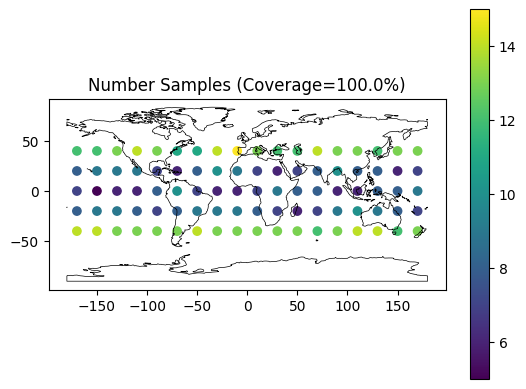

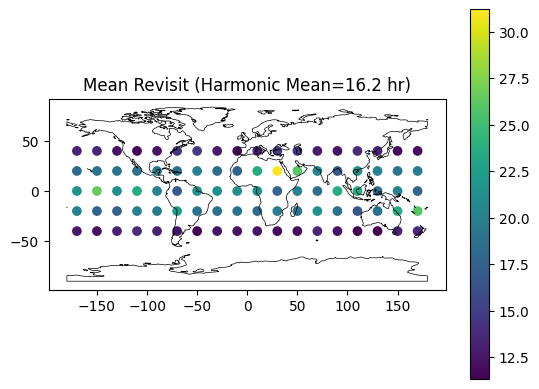

In [5]:
import matplotlib.pyplot as plt

# load shapefile
world = gpd.read_file(
    "https://naciscdn.org/naturalearth/110m/physical/ne_110m_land.zip"
)

# example composite plot using GeoDataFrames
fig, ax = plt.subplots()
ax.set_title(f"Number Samples (Coverage={response2.coverage_fraction:.1%})")
data2.plot(ax=ax, column="number_samples", legend=True)
world.boundary.plot(ax=ax, lw=0.5, color="k")
ax.set_aspect("equal")
plt.show()

# example composite plot using GeoDataFrames
fig, ax = plt.subplots()
ax.set_title(
    f"Mean Revisit (Harmonic Mean={response2.harmonic_mean_revisit/timedelta(hours=1):.1f} hr)"
)
data2["mean_revisit_hr"] = data2.apply(
    lambda r: r["mean_revisit"] / timedelta(hours=1), axis=1
)
data2.plot(ax=ax, column="mean_revisit_hr", legend=True)
world.boundary.plot(ax=ax, lw=0.5, color="k")
ax.set_aspect("equal")
plt.show()